In [1]:
import numpy as np 
import pandas as pd 

### LOAD DATA

In [4]:
with open("data/RateBeer/ratings.txt", encoding="utf-8") as input_file:
    rb_ratings = [next(input_file) for _ in range(17*5882)] # about 1Mil lines (17 is the number of lines for one review for RateBeer)

In [5]:
rb_ratings_text = [x.replace("text: ", "")
                  .replace("\n", "")
                  for x in rb_ratings 
                  if x.startswith("text:")]

rb_ratings_num = [round(float(x.replace("rating: ", "")
                  .replace("\n", "")))
                  for x in rb_ratings 
                  if x.startswith("rating:")]

rb_beer_name = [x.replace("beer_name: ", "")
                  .replace("\n", "")
                  for x in rb_ratings 
                  if x.startswith("beer_name:")] 

In [6]:
dict = {'review': rb_ratings_text, 'score': rb_ratings_num, "beer_name" : rb_beer_name} 
   
data = pd.DataFrame(dict)
len(data)

5882

### REMOVE NON ENGLISH REVIEWS

In [7]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii') # detect all non ascii characters => most of the time not english
    except UnicodeDecodeError:
        return False
    else:
        return True

non_english_lines = [ind for ind, rev in enumerate(data["review"]) if isEnglish(rev)]

In [8]:
data = data.loc[non_english_lines]
len(data)

4496

### EXTRACTING INFO ABOUT BEER FROM REVIEW (TASK 1)

### EMOTIONS REVIEW

In [95]:
from transformers import pipeline

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

c:\Python38\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
emotions = {"anger" : [], "disgust": [], 'fear' : [], 'joy' : [], 'neutral' : [], 'sadness' : [], 'surprise' : []}
total = len(data)

for x in data["review"]:
    if len(x) < 500: # The length constraint is because the model has a length constraint
        result = classifier(x)[0]
        for emotion in result:
            emotions[emotion["label"]].append(emotion["score"])
        if len(emotions["disgust"]) % 100 == 0:
            print(f"{(len(emotions['disgust'])/total * 100):.2f} % done", end='\r') 
    else:
        for y in result:
            emotions[emotion["label"]].append(0)

In [ ]:
for label, values in emotions.items():
    data[label] = values

In [ ]:
# Create a additionnal column representing the feeling with the maximum score according to the model
data["max_feel"] = data[["anger", "disgust", 'fear', 'joy', 'neutral', 'sadness', 'surprise']].idxmax(axis=1)

In [16]:
for i in range(6):
    print(f"When the given rating is {i}, we have the following emotions (in percentage): ")
    print(data[data["score"] == i]["max_feel"].value_counts(normalize=True) * 100)
    print()

When the given rating is 0, we have the following emotions (in percentage): 
max_feel
disgust    71.428571
neutral    14.285714
fear       14.285714
Name: proportion, dtype: float64

When the given rating is 1, we have the following emotions (in percentage): 
max_feel
disgust     65.217391
neutral     13.043478
sadness      7.608696
joy          7.608696
anger        4.347826
fear         1.086957
surprise     1.086957
Name: proportion, dtype: float64

When the given rating is 2, we have the following emotions (in percentage): 
max_feel
disgust     59.363057
neutral     22.547771
joy          7.770701
sadness      4.458599
anger        3.694268
fear         1.656051
surprise     0.509554
Name: proportion, dtype: float64

When the given rating is 3, we have the following emotions (in percentage): 
max_feel
disgust     50.473934
neutral     31.674566
joy         10.031596
anger        4.462875
sadness      2.132701
fear         0.829384
surprise     0.394945
Name: proportion, dtype: floa

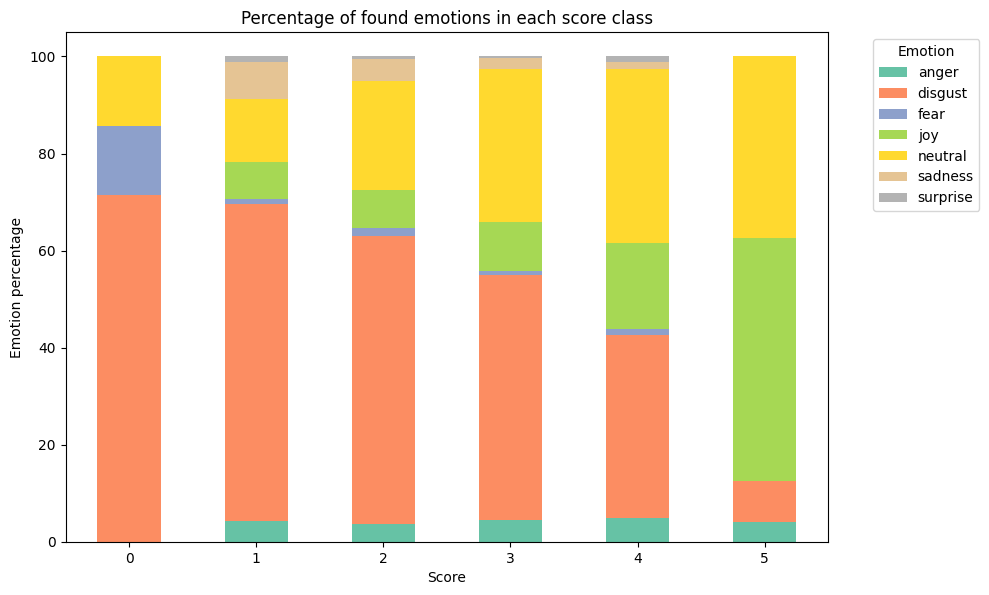

Spearman correlation for emotions by score: 
(if p value < 0.05 we can say that a change in score, introducted a predictable increase or decrease in the percentage for that emotion) 
          Spearman correlation   p-value
anger                 0.542857  0.265703
disgust              -1.000000  0.000000
fear                 -0.714286  0.110787
joy                   1.000000  0.000000
neutral               0.942857  0.004805
sadness              -0.289886  0.577352
surprise             -0.115954  0.826848


In [ ]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Compute counts for each score and emotion
emotion_counts = data.groupby(['score'])["max_feel"].value_counts().unstack(fill_value=0)
# Then their percentage in each score class
emotion_percentages = emotion_counts.div(emotion_counts.sum(axis=1), axis=0) * 100

emotion_percentages.plot(kind='bar', stacked=True, colormap="Set2", figsize=(10, 6))
plt.title("Percentage of found emotions in each score class")
plt.xlabel("Score")
plt.ylabel("Emotion percentage")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

emotion_percentages = emotion_percentages.reset_index()

# Compute the spearman correlation for each emotion between its percentage and its score
spearman_results = {}
for emotion in emotion_counts.columns:
    spearman_corr, p_value = stats.spearmanr(emotion_percentages['score'], emotion_percentages[emotion])
    spearman_results[emotion] = {'Spearman correlation': spearman_corr, 'p-value': p_value}

spearman_df = pd.DataFrame(spearman_results).T
print("Spearman correlation for emotions by score: ")
print("(if p value < 0.05 we can say that a change in score, introducted a predictable increase or decrease in the percentage for that emotion) ")
print(spearman_df)


### Defining Negative reviews (TAKS 2)

##### NEGATIVITY SCORE

In [ ]:
from transformers import pipeline

# We consider negative review to be those with scores 0, 1 or 2, and we will try to find those that have an extreme vocabulary using a 
# sentiment analysis model
negative_reviews = data[(data["score"] == 0) | (data["score"] == 1) | (data["score"] == 2)]

sentiment_task = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

total = len(negative_reviews)
polarity = []
for x in negative_reviews["review"]:
    if len(x) < 500:
        result = sentiment_task(x)[0]
        if result["label"] != "negative":
            polarity.append(0)
        else:
            polarity.append(result["score"])
        if len(polarity) % 100 == 0:
            print(f"{(len(polarity)/total * 100):.2f} % done", end='\r') 
    else:
        polarity.append(0)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
negative_reviews["polarity"] = polarity

C:\Users\luka_\AppData\Local\Temp\ipykernel_32572\3029497157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews["polarity"] = polarity


In [39]:
top_negative_rev = (-negative_reviews[negative_reviews["polarity"] != 0.0]["polarity"]).argsort()

In [ ]:
# 10 most negative reviews according to our model
negative_reviews[negative_reviews["polarity"] != 0.0]["review"].iloc[top_negative_rev[:10]].tolist()

['This is a terrible beer and should be avoided at all costs! The ginseng is so overpowering and gross that it totally kills this beer. Some things just should not be infused into beer! ',
 'oh wow, this is awful. Aroma and flavour smacks of adjuncts. Crappy vegetal, grainy flavour, blech, bad stuff.  ',
 'not very good at all. looks nice, but tastes awful. golden in colour, big white head, horrible taste.  ',
 'Can from FairPrice in Singapore. Golden pour with a huge white head. Plastic, rotten veggies, a drier finish - this is a special kind of bad. ',
 'Meh, very bland lager, luckily the bottle cost be just 69p! Just about drinkable but nothing very enjoyable about it at all. Grainy, grassy, bitter and blande. Very pale in colour too. ',
 'found this in vietnam.  holy bad beer.  this one pours just like a weak looking pale lager then you drink it and it overfows with bad off flavors and overpowering alcohol presence.   cereal backbone of graininess, slighlty sweet. ',
 '500 ml bottl

In [ ]:
# 10 most "positive" reviews (among negatives) according to our model
negative_reviews[negative_reviews["polarity"] != 0.0]["review"].iloc[top_negative_rev[-10:]].tolist()

['thin feel, rather punget smell standard lager smell mixed with a strong smell of sour malt, Terrable flavor sweetness of a lager mixed with a stronger than usual alcohol taste (odd for such a low ABV) stadard hohum lager color. Stick to a nice pils .   ',
 'Amber-ish color with a fine off white head. Dried fruits and to much yeast in this one. Medium + body and a soft carbonation. Tad sweet and a moderate bitterness. Nah not god at all.[On tap at Brewbot in Belfast, Northern Ireland] ',
 'A skunky lager with a touch of some citrusy malt which seemed to go well with Chinese food but unfortunately never seemed to go away afterwards. ',
 "Not much to say...it's beer, but definitely nothing special. If I was living in Singapore and this was the only beer around, I'd love it. Since I don't, it's not exactly my top pick. ",
 'pale, light golden colour.  A sweet fruitiness to it, like a british ale gone bad.  Too fruity, needs more hops.  ',
 'No Head, No Aroma. Really just an innoffensive 

We observe a change in vocabulary used between the two lists of reviews, indicating the model is capable of finding reviews that use a more negative vocabulary.

##### 10 % across beers

In [ ]:
# Here are the 10 % worst reviews 

thresholds = data.groupby("beer_name")["score"].quantile(0.1)

# We get the 10 % lowest score review by adding the threshold column to each beer and comparing the scores for each review to the treshold
low_score_reviews = data.join(thresholds, on="beer_name", rsuffix="_threshold")
low_score_reviews = low_score_reviews[low_score_reviews["score"] <= low_score_reviews["score_threshold"]]

low_score_reviews = low_score_reviews.drop(columns=["score_threshold"])

print(low_score_reviews)

                                                 review  score  \
4     Many thanks for this beer to Erzengel. Pours l...      2   
5     Many thanks to Erzengel for sharing! Pours cle...      2   
8     330ml bottle. 29-05-2014.From Gabon, courtesy ...      2   
9     Light yellow with quickly disappearing foam to...      2   
10    Pours yellow with a large white head.  Smells ...      2   
...                                                 ...    ...   
5828  We have a theory here that the reason why they...      0   
5835  This beer finish is dry, medium fullness and s...      1   
5842  Basically water. Almost no aroma. Bitterness v...      1   
5865  Super-clear and golden-straw in color. Has a q...      1   
5875        Bland with a sharp, unpleasant bitterness.       1   

                beer_name     anger   disgust      fear       joy   neutral  \
4     Castel Beer (Gabon)  0.009796  0.023428  0.002916  0.254752  0.699246   
5     Castel Beer (Gabon)  0.020531  0.110960  0.

In [98]:
# Emotions percentage in 10 % low review
low_score_reviews.groupby("beer_name")["max_feel"].value_counts(normalize=True) * 100

beer_name                      max_feel
ABC Extra Stout                disgust      56.321839
                               neutral      28.735632
                               joy           6.896552
                               anger         5.747126
                               sadness       1.149425
                                              ...    
Whitewater Snake Drive Bitter  disgust      50.000000
Whitewater Solstice            disgust      84.615385
                               joy           7.692308
                               neutral       7.692308
Whitewater St Donard           joy         100.000000
Name: proportion, Length: 795, dtype: float64

In [97]:
# Emotions percentage in all reviews
data.groupby("beer_name")["max_feel"].value_counts(normalize=True) * 100

beer_name                      max_feel
ABC Extra Stout                disgust      50.340136
                               neutral      27.891156
                               joy          11.564626
                               anger         5.442177
                               sadness       3.401361
                                              ...    
Whitewater Snake Drive Bitter  joy          50.000000
Whitewater Solstice            disgust      84.615385
                               neutral       7.692308
                               joy           7.692308
Whitewater St Donard           joy         100.000000
Name: proportion, Length: 1081, dtype: float64